# Florida Voted for Four More Years of Trump... and a $15 Minimum Wage

Among the most surprising results from the 2020 general election was the passage of a gradual minimum wage increase in Florida, a state in which Republicans have dominated statewide elections as of late. The minimum wage amendment cleared the required 60% threshhold with 60.8% support well above President Trump's 51.2% victory over his $15-minimum-wage-supporting opponent, President Biden. To examine these contrasting results, let's scrape the election results from the Florida Division of Elections website and then analyze them using data visualization and regression tools in Python.

To do this, we use the `pandas` library for its `read_html` function and `DataFrame` structure, `requests` for accessing the html of the webpage, `seaborn` for visualizations, and `sklearn` (better known as scikit-learn) for regression. We need to import `numpy` as well to deal with some errors encountered while fitting and scoring the linear model.

In [1]:
import pandas as pd
import requests
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

To get the results from the Florida Division of Elections website using `read_html`, we make use of a trick outlined in this [Stack Overflow post](https://stackoverflow.com/questions/43590153/http-error-403-forbidden-when-reading-html).

In [2]:
url1 = "http://results.elections.myflorida.com/DetailRpt.Asp?ELECTIONDATE=11/3/2020&RACE=PRE&PARTY=&DIST=&GRP=&DATAMODE="
header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}
r1 = requests.get(url1, headers = header)
pres = pd.read_html(r1.text, skiprows = 1, header = 0)[0]

In [3]:
pres

,County,Trump / Pence(REP),Biden / Harris(DEM),Jorgensen / Cohen(LPF),De La Fuente / Richardson(REF),La Riva / Freeman(PSL),Hawkins / Walker(GRE),Blankenship / Mohr(CPF),Carroll / Patel(WRI),Howard / Howard(WRI),Laboch / Pope(WRI),Simmons / Nixon(WRI),Walls-Windhauser / Tolbert(WRI),Wells / Wells(WRI),Unnamed: 14
0,Alachua,50972,89704,1390,70,94,302,52,16,0,0,3,0,1,NaN
1,Baker,11911,2037,93,4,3,10,1,0,0,0,0,0,0,NaN
2,Bay,66097,25614,1004,54,45,142,52,11,0,0,5,0,0,NaN
3,Bradford,10334,3160,110,7,3,11,6,1,0,0,0,0,0,NaN
4,Brevard,207883,148549,3178,222,164,553,171,36,0,0,8,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Walton,32947,10338,336,16,15,43,13,1,0,0,2,0,0,NaN
66,Washington,9876,2347,69,5,10,15,5,0,0,0,0,0,0,NaN
67,Total,5668731,5297045,70324,5966,5712,14721,3902,854,9,1,181,2,8,NaN
68,% Votes,51.2%,47.9%,0.6%,0.1%,0.1%,0.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,NaN


We clean this up a bit by dropping the `Total` and `% Votes` rows as well as the extra row and column included. In addition, we set the index to the `County` column and make sure all the other entries are `int`s. 

In [4]:
pres.drop(index = [67,68,69], columns = 'Unnamed: 14', inplace = True)
pres.set_index('County', inplace = True)
pres = pres.astype(int)
pres

,Trump / Pence(REP),Biden / Harris(DEM),Jorgensen / Cohen(LPF),De La Fuente / Richardson(REF),La Riva / Freeman(PSL),Hawkins / Walker(GRE),Blankenship / Mohr(CPF),Carroll / Patel(WRI),Howard / Howard(WRI),Laboch / Pope(WRI),Simmons / Nixon(WRI),Walls-Windhauser / Tolbert(WRI),Wells / Wells(WRI)
County,,,,,,,,,,,,,
Alachua,50972,89704,1390,70,94,302,52,16,0,0,3,0,1
Baker,11911,2037,93,4,3,10,1,0,0,0,0,0,0
Bay,66097,25614,1004,54,45,142,52,11,0,0,5,0,0
Bradford,10334,3160,110,7,3,11,6,1,0,0,0,0,0
Brevard,207883,148549,3178,222,164,553,171,36,0,0,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Union,5133,1053,42,4,3,5,5,0,0,0,0,0,0
Volusia,173821,130575,2156,160,173,390,141,19,0,0,4,0,0
Wakulla,12874,5351,135,10,6,18,10,0,0,0,0,0,0


Next, we create two new columns: one for the total votes cast in a county in the presidential election and the other for President Trump's share of that vote.

In [5]:
pres['Total_pres'] = pres.sum(axis = 1)
pres['Trump_pct'] = (pres['Trump / Pence(REP)']/pres['Total_pres'] * 100).round(2)

Turning to the minimum wage amendment, we use the same process as above to read those results into a `pandas` `DataFrame` and tidy them up.

In [6]:
url2 = "http://results.elections.myflorida.com/DetailRpt.Asp?ELECTIONDATE=11/3/2020&RACE=A02&PARTY=&DIST=&GRP=&DATAMODE="
r2 = requests.get(url2, headers = header)
min_wage = pd.read_html(r2.text, skiprows = 1, header = 0)[0]
min_wage.drop(index = [67,68,69], columns = 'Unnamed: 3', inplace = True)
min_wage.set_index('County', inplace = True)
min_wage.rename(columns = {'Unnamed: 1': 'Yes', 'Unnamed: 2': 'No'}, inplace = True)
min_wage = min_wage.astype(int)
min_wage

,Yes,No
County,,
Alachua,88302,51751
Baker,4106,9661
Bay,41100,50210
Bradford,4913,8353
Brevard,190619,155353
...,...,...
Union,2147,3989
Volusia,166151,126925
Wakulla,7235,10810


Again, we create new columns to use in the analysis.

In [7]:
min_wage['Total_min_wage'] = min_wage['Yes'] + min_wage['No']
min_wage['Yes_pct'] = (min_wage['Yes']/min_wage['Total_min_wage'] * 100).round(2)
min_wage['No_pct'] = (min_wage['No']/min_wage['Total_min_wage'] * 100).round(2)
min_wage

,Yes,No,Total_min_wage,Yes_pct,No_pct
County,,,,,
Alachua,88302,51751,140053,63.05,36.95
Baker,4106,9661,13767,29.82,70.18
Bay,41100,50210,91310,45.01,54.99
Bradford,4913,8353,13266,37.03,62.97
Brevard,190619,155353,345972,55.10,44.90
...,...,...,...,...,...
Union,2147,3989,6136,34.99,65.01
Volusia,166151,126925,293076,56.69,43.31
Wakulla,7235,10810,18045,40.09,59.91


We then join these two `DataFrames` using the `pandas` `join()` function. 

In [8]:
fl_2020 = pres.join(min_wage)
fl_2020

,Trump / Pence(REP),Biden / Harris(DEM),Jorgensen / Cohen(LPF),De La Fuente / Richardson(REF),La Riva / Freeman(PSL),Hawkins / Walker(GRE),Blankenship / Mohr(CPF),Carroll / Patel(WRI),Howard / Howard(WRI),Laboch / Pope(WRI),Simmons / Nixon(WRI),Walls-Windhauser / Tolbert(WRI),Wells / Wells(WRI),Total_pres,Trump_pct,Yes,No,Total_min_wage,Yes_pct,No_pct
County,,,,,,,,,,,,,,,,,,,,
Alachua,50972,89704,1390,70,94,302,52,16,0,0,3,0,1,142604,35.74,88302,51751,140053,63.05,36.95
Baker,11911,2037,93,4,3,10,1,0,0,0,0,0,0,14059,84.72,4106,9661,13767,29.82,70.18
Bay,66097,25614,1004,54,45,142,52,11,0,0,5,0,0,93024,71.05,41100,50210,91310,45.01,54.99
Bradford,10334,3160,110,7,3,11,6,1,0,0,0,0,0,13632,75.81,4913,8353,13266,37.03,62.97
Brevard,207883,148549,3178,222,164,553,171,36,0,0,8,0,0,360764,57.62,190619,155353,345972,55.10,44.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Union,5133,1053,42,4,3,5,5,0,0,0,0,0,0,6245,82.19,2147,3989,6136,34.99,65.01
Volusia,173821,130575,2156,160,173,390,141,19,0,0,4,0,0,307439,56.54,166151,126925,293076,56.69,43.31
Wakulla,12874,5351,135,10,6,18,10,0,0,0,0,0,0,18404,69.95,7235,10810,18045,40.09,59.91


Before fitting a linear regression model, we can first examine the correlation between the President's share of the vote and the share of Floridians who voted "Yes" on the minimum wage amendment. We can visualize this data with a simple scatterplot:

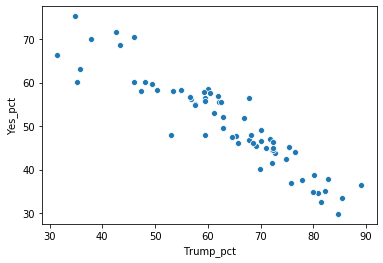

In [9]:
sns.scatterplot(data = fl_2020,  x = 'Trump_pct', y = 'Yes_pct')

As expected, we see a strong negative linear correlation between a county's level of support for the incumbent and the level of support for the amendment. To be more accurate, we calculate the correlation coefficient $R$, which confirms our initial appraisal:

In [10]:
fl_2020['Trump_pct'].corr(fl_2020['Yes_pct'])

-0.9258072201865927

To further describe and model this relationship, we create a Linear Regression object, fit it using the presidential and minimum wage amendment results, and output the regression coefficients.

In [11]:
lm = LinearRegression()
X = fl_2020['Trump_pct']
y = fl_2020['Yes_pct']
lm.fit(np.array(X).reshape(-1,1), y)
print(lm.coef_)
print(lm.intercept_)

[-0.70204422]
95.12148020666736


We can also add our linear model to the scatterplot using the `regplot` function.

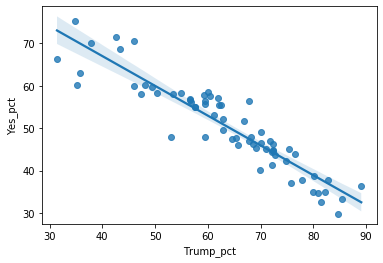

In [12]:
sns.regplot(data = fl_2020, x = 'Trump_pct', y = 'Yes_pct')

From the slope of our linear model (the value of `lm.coef_`), we find that on average for every one point increase in President Trump's share of the presidential vote we see a 0.7 point decrease in the vote for the minimum wage amendment. We can also calculate the coefficient of determination, or $R^2$:

In [13]:
lm.score(np.array(X).reshape(-1,1), y)

0.8571190089496257

This shows that almost 86% of the variation of a county's support for the minimum wage amendment can be explained by its support of the incumbent. What accounts for the other 14%? For a head start on answering this question, we can find which counties strayed the most from the linear model. To do this, we calculate the residual for each county and sort. 

In [14]:
res = (y - lm.predict(np.array(X).reshape(-1,1))).sort_values(ascending = False)

At the top are counties in which the support for the minimum wage amendment was above what our model expected:

In [15]:
res.head()

County
Sumter        9.059240
Miami-Dade    7.764676
Osceola       6.342624
Flagler       5.575214
Martin        5.427180
Name: Yes_pct, dtype: float64

And at the bottom, we find counties where our model predicted higher support for the amendment than it in fact received.

In [16]:
res.tail()

County
Wakulla      -5.923487
Gadsden      -6.633251
Alachua      -6.980420
Jefferson    -9.873137
Leon        -10.257401
Name: Yes_pct, dtype: float64

These results provide but a starting point in a quest to understand why a red-tinged state voted in favor of a rallying cry of the progressive agenda.